In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
import torch.nn as nn

In [2]:
features_stock = pd.read_csv('feature_stock1.csv')
features_stock2 = pd.read_csv('feature_stock2.csv')
features_stock = features_stock2.merge(features_stock, on=['trade_date', 'ts_code'], how='left')
del features_stock2
feature_index = pd.read_csv('feature_index.csv')
features_stock = features_stock.merge(feature_index[['trade_date', 'rate_1', 'rate_2', 'rate_3', 
                                                     'rate', ]], on='trade_date', how='left')
del feature_index

In [3]:
feature_col = ['open_transform', 'close_transform', 'high_transform', 'low_transform',
                   'open_transform_shift_1', 'open_transform_shift_2', 'close_transform_shift_1',
                   'close_transform_shift_2', 'high_transform_shift_1', 'high_transform_shift_2',
                   'low_transform_shift_1', 'low_transform_shift_2', 'rate', 'rate_1', 'rate_2', 'rate_3',
                   'open_transform_3', 'close_3', 'turnover_rate',
                   'pingjun_3', 'turnover_rate_shift_1', 'turnover_rate_shift_2', 'weekday',
                   'zhenfu', 'zhenfu_shift_1', 'zhenfu_shift_2', 'high_10', 'low_10', 'high_20', 'low_20'
                   ]

In [4]:
features_stock = features_stock.rename(columns={'ts_code':'name', 'trade_date':'day', 'close':'close_price'})
features = features_stock
features = features.dropna().reset_index(drop=True)
features['label'] = ((features['next_close'] / features['close_price'] - 1) > 0)
features['rate_stock'] = (features['next_close'] / features['close_price'] - 1)

In [5]:
features['label'] = features['label'].astype('int')

In [6]:
train_date_min = 20170101
train_date_max = 20190101

val_date_min = 20190102
val_date_max = 20200101

In [7]:
df = features
idx = (df['day']>=train_date_min) & (df['day']<=train_date_max)
for tmp_col in feature_col:
    max_ = np.percentile(df[idx][tmp_col], 99.99)
    df.loc[df[tmp_col]>max_, tmp_col] = max_
    min_ = np.percentile(df[idx][tmp_col], 0.01)
    df.loc[df[tmp_col]<min_, tmp_col] = min_
    
    df[tmp_col] = (df[tmp_col] - df[idx][tmp_col].mean()) / (df[idx][tmp_col].std() + 1e-6)

In [8]:

# 获取class的天和time
train_data = []
train_label = []
test_data = []
test_label = []

trn_time_start = []  # 起始时间
val_time_start = []  # 测试起始时间
classes = []
class_dict = dict()
data_len = 10
num = -1

df_test_all = []

for i, g in tqdm(df.groupby(['name'])):
    num = num + 1
    class_dict[num] = i
    classes.append(num)
    
    g = g.reset_index(drop=True)
    g = g.sort_values(['day'], ascending=[True]).reset_index(drop=True)
    g_trn = g[(g['day'] >= train_date_min) & (g['day'] <= train_date_max)].reset_index(drop=True)
    
    if len(g_trn) < data_len:
        train_data.append([])
        train_label.append([])
        trn_time_start.append([])
#         print('%s has no training data' % i)
    else:

        train_data.append(g_trn[feature_col].values)
        train_label.append(g_trn['label'].values)
        trn_time_start.append(list(range(len(g_trn) - data_len + 1)))
    
    idx = g[(g['day'] >= val_date_min) & (g['day'] <= val_date_max)].index  
    if len(idx) < data_len:
        val_time_start.append([])
        test_data.append([])
        test_label.append([])

    else:
        st = max(idx[0] - data_len + 1, 0)
        et = idx[-1]
        g_test = g.loc[st:et]
        val_time_start.append(list(range(len(g_test) - data_len + 1)))
        test_data.append(g_test[feature_col].values)
        test_label.append(g_test['label'].values)
        df_test_all.append(g.loc[st + data_len - 1:et][['name', 'day', 'label', 'next_close', 'close_price', 'is_limit']])
df_test_all = pd.concat(df_test_all)   

100%|██████████| 2890/2890 [00:14<00:00, 199.73it/s]


In [9]:
# 生成训练idx
idxs = []
for i in range(len(classes)):
    tmp_t = trn_time_start[i]
    tmp_t = np.reshape(tmp_t, (-1, 1))
    if len(trn_time_start[i]) <= 0:
        continue
    tmp_c = np.ones((len(trn_time_start[i]), 1)) * classes[i]
    idxs.append(np.concatenate([tmp_c, tmp_t], axis=1))
    

idxs = np.concatenate(idxs, axis=0)
df_sample_trn = pd.DataFrame(idxs, columns=['id', 'st'])
df_sample_trn['id'] = df_sample_trn['id'].astype(int)
df_sample_trn['st'] = df_sample_trn['st'].astype(int)

idxs = []

for i in range(len(classes)):
    test_ = test_data[i]
    tmp_t = val_time_start[i]
    tmp_t = np.reshape(tmp_t, (-1, 1))
    if len(val_time_start[i]) <= 0:
        continue
    tmp_c = np.ones((len(val_time_start[i]), 1)) * classes[i]
    idxs.append(np.concatenate([tmp_c, tmp_t], axis=1))

    assert len(test_)-data_len+1 == len(val_time_start[i])

idxs = np.concatenate(idxs, axis=0)
df_sample_test = pd.DataFrame(idxs, columns=['id', 'st'])
df_sample_test['id'] = df_sample_test['id'].astype(int)
df_sample_test['st'] = df_sample_test['st'].astype(int)

In [10]:
class lstm(nn.Module):
    def __init__(self, in_dim):
        super(lstm, self).__init__()
        self.lstm1 = nn.LSTM(in_dim, 64, 1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(128, 128, 1, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x, (_, _) = self.lstm1(x)
        x, (_, _) = self.lstm2(x)
        #         print(x.shape)
        x = self.fc(x[:, -1, :].reshape((x.size(0), -1)))
        return x

In [11]:
def train_epoch(model, optimizer, criterion, train_dataloader, val_dataloader):
    model.train()
    f1_meter, loss_meter, it_count = 0, 0, 0
    tq = tqdm(range(len(train_dataloader)))
    for i, (inputs, target) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        target = target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        output = model(inputs)
        output = torch.sigmoid(output)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_meter += loss.item()
        it_count += 1
        tq.set_description('batch: %d, loss: %.3f' % (i, loss.item()))
        tq.update(1)
    tq.close()
    return loss_meter / it_count

def val_epoch(model, criterion, val_dataloade):
    model.eval()
    loss_meter, it_count = 0, 0

    with torch.no_grad():
        if torch.cuda.is_available():
            label_all = torch.FloatTensor().cuda()
            pred_all = torch.FloatTensor().cuda()
        else:
            label_all = torch.FloatTensor()
            pred_all = torch.FloatTensor()

        num = 0
        for inputs, target in tqdm(val_dataloader):
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            output = torch.sigmoid(output)
            it_count += 1
            label_all = torch.cat((label_all, target), 0)
            pred_all = torch.cat((pred_all, output), 0)

        output = pred_all.cpu().detach().numpy()
        target = label_all.cpu().detach().numpy()
        
        loss = np.mean(target * np.log(output) + (1-target) * np.log((1-output)))
#         loss = np.mean(np.abs(output - target))

    return loss, target, output

In [12]:
class MyDataset(Dataset):
    def __init__(self, df_sample, data, label, data_len, train=True):
        super(MyDataset, self).__init__()
        self.df_sample = df_sample.values
        self.data_len = data_len
        self.label = label
        self.data = data
        

    def __getitem__(self, index):

        idx = int(self.df_sample[index][0])
        st = int(self.df_sample[index][1])
        tmp_data = self.data[idx]
        tmp_label = self.label[idx]
        x = tmp_data[st:st + self.data_len]
        y = tmp_label[st + self.data_len-1]
        y = np.reshape(y, (-1))
        x = np.reshape(x, (self.data_len, len(feature_col)))
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.df_sample)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
label_col = 'label'

In [14]:
inchannels = len(feature_col)
model = lstm(inchannels)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
train_dataset = MyDataset(df_sample_trn, train_data, train_label, data_len,)
val_dataset = MyDataset(df_sample_test, test_data, test_label, data_len,)

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1024, num_workers=4)


In [15]:
max_epoch = 1
for i in range(max_epoch):
    trn_loss = train_epoch(model, optimizer, criterion, train_dataloader, val_dataloader)
    model_save_dir = 'model_lstm_' + str(i+1) + '.pth'
    torch.save(model.state_dict(), model_save_dir)
    print(trn_loss)

batch: 1169, loss: 0.647: 100%|██████████| 1170/1170 [00:26<00:00, 43.89it/s]


0.6709637782512567


In [16]:
loss, target, output = val_epoch(model, criterion, val_dataloader)

100%|██████████| 672/672 [00:08<00:00, 82.56it/s] 


In [17]:
day_list = sorted(df_test_all['day'].unique())
oof = output > 0.5
print('acc: %.4f' % metrics.accuracy_score(target, oof))
print(metrics.confusion_matrix(target, oof))

oof = output > 0.6
acc2 = np.sum(oof * target) / np.sum(oof)
print('precision: %.4f' % acc2)

acc: 0.5248
[[252480  96119]
 [230562 108246]]
precision: 0.5413


In [18]:
buy_df = df_test_all.copy()
buy_df['pred'] = oof
buy_df['prob'] = output
idx = (buy_df['is_limit']==False) & (buy_df['pred']==1) #&(buy_df['close_transform']<1.15)
buy_df = buy_df[idx]
buy_df['next_open'] = buy_df['next_close']

In [19]:
from imp import reload
import Account
reload(Account)
money_init = 100000
account = Account.Account(money_init)
account.BackTest(buy_df, sorted(day_list), buy_price='close_price')

20190102  买入 600521.SH (600521.SH) 2100股，股价：9.4476,花费：19839.96,手续费：5.95，剩余现金：80154.09
20190102  买入 603108.SH (603108.SH) 2800股，股价：7.0009,花费：19602.52,手续费：5.88，剩余现金：60545.69
20190102  买入 600745.SH (600745.SH) 900股，股价：20.9104,花费：18819.36,手续费：5.65，剩余现金：41720.68
20190102  买入 002787.SZ (002787.SZ) 3000股，股价：6.4829,花费：19448.7,手续费：5.83，剩余现金：22266.15
20190102  买入 002847.SZ (002847.SZ) 900股，股价：20.5534,花费：18498.06,手续费：5.55，剩余现金：3762.54
20190103  止损卖出 (600521.SH) 2100股，股价：8.9869,收入：18872.49,手续费：24.53，剩余现金：22610.49，最终亏损：-997.96
20190103  止损卖出 (603108.SH) 2800股，股价：6.8919,收入：19297.32,手续费：25.09，剩余现金：41882.73，最终亏损：-336.17
20190103  止损卖出 (600745.SH) 900股，股价：19.192,收入：17272.8,手续费：22.45，剩余现金：59133.07，最终亏损：-1574.66
20190103  止盈卖出 (002787.SZ) 3000股，股价：6.5515,收入：19654.5,手续费：25.55，剩余现金：78762.02，最终盈利：174.41
20190103  止损卖出 (002847.SZ) 900股，股价：20.4649,收入：18418.41,手续费：23.94，剩余现金：97156.49，最终亏损：-109.14
20190103  买入 001872.SZ (001872.SZ) 1400股，股价：13.482999999999999,花费：18876.2,手续费：5.66，剩余现金：78274.62
20190103  买入 00259

20190129  买入 603283.SH (603283.SH) 1400股，股价：15.4788,花费：21670.32,手续费：6.5，剩余现金：1148.82
20190130  止损卖出 (002684.SZ) 3600股，股价：5.78,收入：20808.0,手续费：27.05，剩余现金：21929.77，最终亏损：-753.51
20190130  止损卖出 (002883.SZ) 1700股，股价：12.3672,收入：21024.24,手续费：27.33，剩余现金：42926.68，最终亏损：-123.09
20190130  止损卖出 (002075.SZ) 3000股，股价：6.9038,收入：20711.4,手续费：26.92，剩余现金：63611.16，最终亏损：-804.67
20190130  止盈卖出 (603329.SH) 1500股，股价：13.995999999999999,收入：20994.0,手续费：27.29，剩余现金：84577.86，最终盈利：40.38
20190130  止损卖出 (603283.SH) 1400股，股价：14.9534,收入：20934.76,手续费：27.22，剩余现金：105485.41，最终亏损：-769.28
20190130  买入 000605.SZ (000605.SZ) 2400股，股价：8.748,花费：20995.2,手续费：6.3，剩余现金：84483.91
20190130  买入 603329.SH (603329.SH) 1500股，股价：13.995999999999999,花费：20994.0,手续费：6.3，剩余现金：63483.61
20190130  买入 002417.SZ (002417.SZ) 2900股，股价：7.43,花费：21547.0,手续费：6.46，剩余现金：41930.15
20190130  买入 600146.SH (600146.SH) 3900股，股价：5.44,花费：21216.0,手续费：6.36，剩余现金：20707.78
20190130  买入 002420.SZ (002420.SZ) 6600股，股价：3.11,花费：20526.0,手续费：6.16，剩余现金：175.62
20190131  止损卖出 (00060

20190312  止盈卖出 (600556.SH) 1800股，股价：7.3025,收入：13144.5,手续费：18.14，剩余现金：149424.64，最终盈利：282.5
20190313  买入 603032.SH (603032.SH) 800股，股价：35.8708,花费：28696.64,手续费：8.61，剩余现金：120719.39
20190313  买入 002656.SZ (002656.SZ) 4400股，股价：6.71,花费：29524.0,手续费：8.86，剩余现金：91186.54
20190313  买入 601860.SH (601860.SH) 3300股，股价：9.0183,花费：29760.39,手续费：8.93，剩余现金：61417.22
20190313  买入 002319.SZ (002319.SZ) 2200股，股价：13.0,花费：28600.0,手续费：8.58，剩余现金：32808.64
20190313  买入 601068.SH (601068.SH) 4000股，股价：7.3433,花费：29373.2,手续费：8.81，剩余现金：3426.63
20190314  止盈卖出 (603032.SH) 800股，股价：36.7287,收入：29382.96,手续费：38.2，剩余现金：32771.39，最终盈利：639.51
20190314  止盈卖出 (002656.SZ) 4400股，股价：6.93,收入：30492.0,手续费：39.64，剩余现金：63223.75，最终盈利：919.5
20190314  止损卖出 (601860.SH) 3300股，股价：8.8739,收入：29283.87,手续费：38.07，剩余现金：92469.55，最终亏损：-523.52
20190314  止盈卖出 (002319.SZ) 2200股，股价：13.75,收入：30250.0,手续费：39.33，剩余现金：122680.22，最终盈利：1602.09
20190314  止损卖出 (601068.SH) 4000股，股价：7.0547,收入：28218.8,手续费：36.68，剩余现金：150862.34，最终亏损：-1199.9
20190314  买入 600892.SH (600892.SH) 

20190412  止盈卖出 (600088.SH) 1600股，股价：20.7002,收入：33120.32,手续费：43.06，剩余现金：67044.81，最终盈利：911.62
20190412  止损卖出 (002468.SZ) 1300股，股价：23.9539,收入：31140.07,手续费：40.48，剩余现金：98144.4，最终亏损：-277.78
20190412  止盈卖出 (002656.SZ) 4800股，股价：7.29,收入：34992.0,手续费：45.49，剩余现金：133090.91，最终盈利：3112.96
20190412  止盈卖出 (000607.SZ) 5200股，股价：6.7556,收入：35129.12,手续费：45.67，剩余现金：168174.36，最终盈利：3162.0
20190412  买入 002239.SZ (002239.SZ) 11900股，股价：2.71,花费：32249.0,手续费：9.67，剩余现金：135915.68
20190412  买入 600113.SH (600113.SH) 3800股，股价：8.2902,花费：31502.76,手续费：9.45，剩余现金：104403.47
20190412  买入 002420.SZ (002420.SZ) 7600股，股价：4.23,花费：32148.0,手续费：9.64，剩余现金：72245.83
20190412  买入 002519.SZ (002519.SZ) 6500股，股价：4.9,花费：31850.0,手续费：9.56，剩余现金：40386.27
20190412  买入 002468.SZ (002468.SZ) 1300股，股价：23.9539,花费：31140.07,手续费：9.34，剩余现金：9236.86
20190412  买入 600122.SH (600122.SH) 1900股，股价：4.78,花费：9082.0,手续费：5，剩余现金：149.86
20190415  止损卖出 (002239.SZ) 11900股，股价：2.63,收入：31297.0,手续费：40.69，剩余现金：31406.17，最终亏损：-1002.36
20190415  止盈卖出 (600113.SH) 3800股，股价：8.6455,

20190508  买入 002473.SZ (002473.SZ) 3700股，股价：8.42,花费：31154.0,手续费：9.35，剩余现金：126220.51
20190508  买入 000565.SZ (000565.SZ) 5600股，股价：5.4789,花费：30681.84,手续费：9.2，剩余现金：95529.47
20190508  买入 600719.SH (600719.SH) 5500股，股价：5.5967,花费：30781.85,手续费：9.23，剩余现金：64738.39
20190508  买入 002800.SZ (002800.SZ) 1500股，股价：19.5226,花费：29283.9,手续费：8.79，剩余现金：35445.7
20190508  买入 002227.SZ (002227.SZ) 2500股，股价：12.2944,花费：30736.0,手续费：9.22，剩余现金：4700.48
20190509  止损卖出 (002473.SZ) 3700股，股价：8.15,收入：30155.0,手续费：39.2，剩余现金：34816.28，最终亏损：-1047.55
20190509  止损卖出 (000565.SZ) 5600股，股价：5.4391,收入：30458.96,手续费：39.6，剩余现金：65235.64，最终亏损：-271.68
20190509  止盈卖出 (600719.SH) 5500股，股价：5.6765,收入：31220.75,手续费：40.59，剩余现金：96415.8，最终盈利：389.08
20190509  止损卖出 (002800.SZ) 1500股，股价：19.0047,收入：28507.05,手续费：37.06，剩余现金：124885.8，最终亏损：-822.69
20190509  止损卖出 (002227.SZ) 2500股，股价：12.2645,收入：30661.25,手续费：39.86，剩余现金：155507.19，最终亏损：-123.83
20190509  买入 603598.SH (603598.SH) 3600股，股价：8.52,花费：30672.0,手续费：9.2，剩余现金：124825.98
20190509  买入 600735.SH (600735.SH) 

20190529  买入 002537.SZ (002537.SZ) 700股，股价：7.7743,花费：5442.01,手续费：5，剩余现金：607.25
20190530  止盈卖出 (000333.SZ) 600股，股价：48.1484,收入：28889.04,手续费：37.56，剩余现金：29458.73，最终盈利：167.02
20190530  止盈卖出 (002569.SZ) 3200股，股价：10.76,收入：34432.0,手续费：44.76，剩余现金：63845.97，最终盈利：1577.4
20190530  止损卖出 (002676.SZ) 9200股，股价：3.35,收入：30820.0,手续费：40.07，剩余现金：94625.91，最终亏损：-2442.03
20190530  止盈卖出 (000150.SZ) 5300股，股价：6.39,收入：33867.0,手续费：44.03，剩余现金：128448.88，最终盈利：422.96
20190530  止损卖出 (603602.SH) 2100股，股价：15.7692,收入：33115.32,手续费：43.05，剩余现金：161521.15，最终亏损：-327.12
20190530  止盈卖出 (002537.SZ) 700股，股价：7.9629,收入：5574.03,手续费：10.57，剩余现金：167084.61，最终盈利：116.45
20190530  买入 002788.SZ (002788.SZ) 3800股，股价：8.619,花费：32752.2,手续费：9.83，剩余现金：134322.58
20190530  买入 002676.SZ (002676.SZ) 10000股，股价：3.35,花费：33500.0,手续费：10.05，剩余现金：100812.53
20190530  买入 002451.SZ (002451.SZ) 2900股，股价：11.19,花费：32451.0,手续费：9.74，剩余现金：68351.79
20190530  买入 603801.SH (603801.SH) 1800股，股价：18.5944,花费：33469.92,手续费：10.04，剩余现金：34871.83
20190530  买入 000789.SZ (000789.SZ) 

20190621  买入 600186.SH (600186.SH) 26400股，股价：1.3468,花费：35555.52,手续费：10.67，剩余现金：142785.68
20190621  买入 002586.SZ (002586.SZ) 8700股，股价：4.0799,花费：35495.13,手续费：10.65，剩余现金：107279.9
20190621  买入 000911.SZ (000911.SZ) 5700股，股价：6.19,花费：35283.0,手续费：10.58，剩余现金：71986.32
20190621  买入 600422.SH (600422.SH) 2700股，股价：12.972000000000001,花费：35024.4,手续费：10.51，剩余现金：36951.41
20190621  买入 002634.SZ (002634.SZ) 5900股，股价：5.98,花费：35282.0,手续费：10.58，剩余现金：1658.82
20190624  止损卖出 (600186.SH) 26400股，股价：1.3468,收入：35555.52,手续费：46.22，剩余现金：37168.12，最终亏损：-56.89
20190624  止损卖出 (002586.SZ) 8700股，股价：3.9743,收入：34576.41,手续费：44.95，剩余现金：71699.58，最终亏损：-974.32
20190624  止损卖出 (000911.SZ) 5700股，股价：6.09,收入：34713.0,手续费：45.13，剩余现金：106367.46，最终亏损：-625.71
20190624  止盈卖出 (600422.SH) 2700股，股价：13.7852,收入：37220.04,手续费：48.39，剩余现金：143539.11，最终盈利：2136.75
20190624  止盈卖出 (002634.SZ) 5900股，股价：6.02,收入：35518.0,手续费：46.17，剩余现金：179010.94，最终盈利：179.24
20190624  买入 002586.SZ (002586.SZ) 8900股，股价：3.9743,花费：35371.27,手续费：10.61，剩余现金：143629.05
20190624  买入 0

20190716  止损卖出 (603797.SH) 3800股，股价：9.1508,收入：34773.04,手续费：45.2，剩余现金：144242.77，最终亏损：-109.23
20190716  止盈卖出 (603828.SH) 5400股，股价：6.4312,收入：34728.48,手续费：45.15，剩余现金：178926.1，最终盈利：-13.97
20190716  买入 000663.SZ (000663.SZ) 5300股，股价：6.58,花费：34874.0,手续费：10.46，剩余现金：144041.64
20190716  买入 600132.SH (600132.SH) 800股，股价：40.2254,花费：32180.32,手续费：9.65，剩余现金：111851.66
20190716  买入 603027.SH (603027.SH) 2200股，股价：15.3653,花费：33803.66,手续费：10.14，剩余现金：78037.86
20190716  买入 600004.SH (600004.SH) 2100股，股价：16.7263,花费：35125.23,手续费：10.54，剩余现金：42902.1
20190716  买入 000732.SZ (000732.SZ) 4900股，股价：7.09,花费：34741.0,手续费：10.42，剩余现金：8150.67
20190716  买入 002038.SZ (002038.SZ) 500股，股价：14.2007,花费：7100.35,手续费：5，剩余现金：1045.32
20190717  止损卖出 (000663.SZ) 5300股，股价：6.52,收入：34556.0,手续费：44.92，剩余现金：35556.4，最终亏损：-373.39
20190717  止损卖出 (600132.SH) 800股，股价：40.0886,收入：32070.88,手续费：41.69，剩余现金：67585.59，最终亏损：-160.79
20190717  止损卖出 (603027.SH) 2200股，股价：15.1232,收入：33271.04,手续费：43.25，剩余现金：100813.38，最终亏损：-586.01
20190717  止损卖出 (600004.SH) 2100股

20190807  止损卖出 (603790.SH) 2200股，股价：15.4371,收入：33961.62,手续费：44.15，剩余现金：173076.84，最终亏损：-488.31
20190807  买入 002234.SZ (002234.SZ) 1000股，股价：34.1828,花费：34182.8,手续费：10.25，剩余现金：138883.78
20190807  买入 002458.SZ (002458.SZ) 2500股，股价：13.8387,花费：34596.75,手续费：10.38，剩余现金：104276.65
20190807  买入 601606.SH (601606.SH) 2500股，股价：13.6392,花费：34098.0,手续费：10.23，剩余现金：70168.42
20190807  买入 002848.SZ (002848.SZ) 2500股，股价：13.66,花费：34150.0,手续费：10.24，剩余现金：36008.18
20190807  买入 002870.SZ (002870.SZ) 1600股，股价：21.0937,花费：33749.92,手续费：10.12，剩余现金：2248.13
20190808  止损卖出 (002234.SZ) 1000股，股价：33.9589,收入：33958.9,手续费：44.15，剩余现金：36162.89，最终亏损：-278.3
20190808  止损卖出 (002458.SZ) 2500股，股价：13.7038,收入：34259.5,手续费：44.54，剩余现金：70377.85，最终亏损：-392.17
20190808  止盈卖出 (601606.SH) 2500股，股价：13.8785,收入：34696.25,手续费：45.11，剩余现金：105028.99，最终盈利：542.92
20190808  止盈卖出 (002848.SZ) 2500股，股价：14.71,收入：36775.0,手续费：47.81，剩余现金：141756.19，最终盈利：2566.95
20190808  止盈卖出 (002870.SZ) 1600股，股价：21.2126,收入：33940.16,手续费：44.12，剩余现金：175652.22，最终盈利：135.99
20190808  

20190903  止损卖出 (600112.SH) 14700股，股价：2.48,收入：36456.0,手续费：47.39，剩余现金：143963.33，最终亏损：-205.37
20190903  止损卖出 (002435.SZ) 8700股，股价：4.14,收入：36018.0,手续费：46.82，剩余现金：179934.5，最终亏损：-405.73
20190903  止盈卖出 (000021.SZ) 700股，股价：12.2476,收入：8573.32,手续费：13.57，剩余现金：188494.25，最终盈利：763.33
20190903  买入 603486.SH (603486.SH) 1500股，股价：25.0,花费：37500.0,手续费：11.25，剩余现金：150983.0
20190903  买入 600511.SH (600511.SH) 1300股，股价：28.471999999999998,花费：37013.6,手续费：11.1，剩余现金：113958.3
20190903  买入 600112.SH (600112.SH) 15200股，股价：2.48,花费：37696.0,手续费：11.31，剩余现金：76250.99
20190903  买入 000982.SZ (000982.SZ) 22900股，股价：1.65,花费：37785.0,手续费：11.34，剩余现金：38454.65
20190903  买入 000007.SZ (000007.SZ) 4600股，股价：8.13,花费：37398.0,手续费：11.22，剩余现金：1045.43
20190904  止盈卖出 (603486.SH) 1500股，股价：25.05,收入：37575.0,手续费：48.85，剩余现金：38571.59，最终盈利：14.9
20190904  止损卖出 (600511.SH) 1300股，股价：28.3244,收入：36821.72,手续费：47.87，剩余现金：75345.44，最终亏损：-250.85
20190904  止盈卖出 (600112.SH) 15200股，股价：2.51,收入：38152.0,手续费：49.6，剩余现金：113447.84，最终盈利：395.09
20190904  止盈卖出 (000982.SZ)

20191010  买入 002956.SZ (002956.SZ) 1400股，股价：25.7016,花费：35982.24,手续费：10.79，剩余现金：152244.18
20191010  买入 603185.SH (603185.SH) 1700股，股价：21.0289,花费：35749.13,手续费：10.72，剩余现金：116484.33
20191010  买入 601258.SH (601258.SH) 30700股，股价：1.2159,花费：37328.13,手续费：11.2，剩余现金：79145.0
20191010  买入 000519.SZ (000519.SZ) 4600股，股价：7.9936,花费：36770.56,手续费：11.03，剩余现金：42363.41
20191010  买入 002955.SZ (002955.SZ) 1000股，股价：35.4706,花费：35470.6,手续费：10.64，剩余现金：6882.17
20191010  买入 000566.SZ (000566.SZ) 1000股，股价：6.33,花费：6330.0,手续费：5，剩余现金：547.17
20191011  止损卖出 (002956.SZ) 1400股，股价：25.1748,收入：35244.72,手续费：45.82，剩余现金：35746.07，最终亏损：-794.13
20191011  止盈卖出 (603185.SH) 1700股，股价：21.2808,收入：36177.36,手续费：47.03，剩余现金：71876.4，最终盈利：370.47
20191011  止损卖出 (601258.SH) 30700股，股价：1.2159,收入：37328.13,手续费：48.53，剩余现金：109156.0，最终亏损：-59.73
20191011  止损卖出 (000519.SZ) 4600股，股价：7.9438,收入：36541.48,手续费：47.5，剩余现金：145649.98，最终亏损：-287.62
20191011  止损卖出 (002955.SZ) 1000股，股价：35.2941,收入：35294.1,手续费：45.88，剩余现金：180898.19，最终亏损：-233.02
20191011  止损卖出 (000566.SZ

20191101  买入 002853.SZ (002853.SZ) 2000股，股价：17.2109,花费：34421.8,手续费：10.33，剩余现金：38419.43
20191101  买入 600732.SH (600732.SH) 4900股，股价：7.28,花费：35672.0,手续费：10.7，剩余现金：2736.73
20191104  止损卖出 (601519.SH) 4800股，股价：7.44,收入：35712.0,手续费：46.43，剩余现金：38402.3，最终亏损：-57.14
20191104  止损卖出 (000893.SZ) 5200股，股价：6.71,收入：34892.0,手续费：45.36，剩余现金：73248.94，最终亏损：-471.95
20191104  止盈卖出 (603712.SH) 1600股，股价：22.2734,收入：35637.44,手续费：46.33，剩余现金：108840.05，最终盈利：6.84
20191104  止盈卖出 (002853.SZ) 2000股，股价：17.695,收入：35390.0,手续费：46.01，剩余现金：144184.05，最终盈利：911.87
20191104  止盈卖出 (600732.SH) 4900股，股价：7.47,收入：36603.0,手续费：47.58，剩余现金：180739.46，最终盈利：872.71
20191104  买入 000158.SZ (000158.SZ) 5500股，股价：6.45,花费：35475.0,手续费：10.64，剩余现金：145253.82
20191104  买入 603797.SH (603797.SH) 4200股，股价：8.5017,花费：35707.14,手续费：10.71，剩余现金：109535.97
20191104  买入 600209.SH (600209.SH) 14400股，股价：2.48,花费：35712.0,手续费：10.71，剩余现金：73813.26
20191104  买入 000156.SZ (000156.SZ) 4400股，股价：8.1324,花费：35782.56,手续费：10.73，剩余现金：38019.96
20191104  买入 600279.SH (600279.SH) 8600

20191125  止损卖出 (002512.SZ) 6600股，股价：5.09,收入：33594.0,手续费：43.67，剩余现金：34836.97，最终亏损：-185.79
20191125  止损卖出 (002485.SZ) 5400股，股价：6.18,收入：33372.0,手续费：43.38，剩余现金：68165.58，最终亏损：-431.51
20191125  止损卖出 (603881.SH) 900股，股价：36.1741,收入：32556.69,手续费：42.32，剩余现金：100679.95，最终亏损：-564.7
20191125  止盈卖出 (600877.SH) 7000股，股价：4.89,收入：34230.0,手续费：44.5，剩余现金：134865.45，最终盈利：785.48
20191125  止损卖出 (002177.SZ) 6100股，股价：5.31,收入：32391.0,手续费：42.11，剩余现金：167214.34，最终亏损：-1028.12
20191125  买入 002252.SZ (002252.SZ) 4600股，股价：7.303,花费：33593.8,手续费：10.08，剩余现金：133610.46
20191125  买入 002947.SZ (002947.SZ) 600股，股价：51.1493,花费：30689.58,手续费：9.21，剩余现金：102911.68
20191125  买入 603068.SH (603068.SH) 300股，股价：87.8118,花费：26343.54,手续费：7.9，剩余现金：76560.23
20191125  买入 600572.SH (600572.SH) 5200股，股价：6.37,花费：33124.0,手续费：9.94，剩余现金：43426.3
20191125  买入 603933.SH (603933.SH) 2300股，股价：14.2738,花费：32829.74,手续费：9.85，剩余现金：10586.71
20191125  买入 603256.SH (603256.SH) 700股，股价：14.4339,花费：10103.73,手续费：5，剩余现金：477.98
20191126  止盈卖出 (002252.SZ) 4600股，股价：7.37299

20191223  买入 603123.SH (603123.SH) 5200股，股价：6.6489,花费：34574.28,手续费：10.37，剩余现金：32867.24
20191223  买入 600105.SH (600105.SH) 7300股，股价：4.456,花费：32528.8,手续费：9.76，剩余现金：328.68
20191224  止盈卖出 (600226.SH) 11500股，股价：3.13,收入：35995.0,手续费：46.79，剩余现金：36276.88，最终盈利：1322.82
20191224  止盈卖出 (600093.SH) 2500股，股价：13.98,收入：34950.0,手续费：45.44，剩余现金：71181.45，最终盈利：344.2
20191224  止盈卖出 (002235.SZ) 4000股，股价：8.67,收入：34680.0,手续费：45.08，剩余现金：105816.37，最终盈利：544.69
20191224  止盈卖出 (603123.SH) 5200股，股价：6.6983,收入：34831.16,手续费：45.28，剩余现金：140602.24，最终盈利：201.23
20191224  止盈卖出 (600105.SH) 7300股，股价：4.5252,收入：33033.96,手续费：42.94，剩余现金：173593.26，最终盈利：452.46
20191224  买入 600226.SH (600226.SH) 10900股，股价：3.13,花费：34117.0,手续费：10.24，剩余现金：139466.03
20191224  买入 600206.SH (600206.SH) 2800股，股价：11.9228,花费：33383.84,手续费：10.02，剩余现金：106072.17
20191224  买入 600093.SH (600093.SH) 2400股，股价：13.98,花费：33552.0,手续费：10.07，剩余现金：72510.1
20191224  买入 000949.SZ (000949.SZ) 8000股，股价：4.2375,花费：33900.0,手续费：10.17，剩余现金：38599.93
20191224  买入 002235.SZ (002235.SZ) 

In [20]:
account_profit = (account.market_value - money_init) / money_init
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

账户盈利情况:0.7504
交易胜率:0.5418
最大回撤率:0.1667


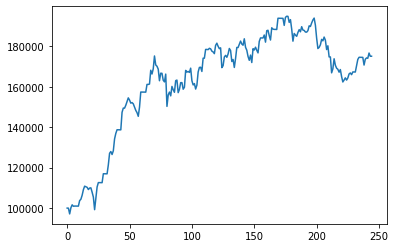

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(account.market_value_all)
plt.show()